# Using Bayesian methods to fit HLMs with non-informative priors
Evan Edwards

In [1]:
%%capture --no-display
# Imports
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# Load dataset
PISA2018 = pd.read_csv("pisa2018.BayesBook.csv")

In [3]:
# Data processing: converting categorical values to numerical values
PISA2018['Female'] = PISA2018['Female'].replace({'Female': 1, 'Male': 0})
# Converting numerical to categorical values
PISA2018['SchoolID'] = pd.Categorical(PISA2018['SchoolID'])

In [4]:
%%capture --no-display
# Create the model
with pm.Model() as non_informative_priors_HLM:
    # Priors
    alpha = pm.Cauchy('alpha', alpha=0, beta=100)  # Intercept
    beta_female = pm.Moyal('beta_female', mu=0, sigma=100)  # Coefficient for Female
    beta_escs = pm.Rice('beta_escs', nu=0, sigma=100)  # Coefficient for ESCS

    # Random intercept for SchoolID
    sigma_school = pm.HalfNormal('sigma_school', sigma=100)
    intercept_school = pm.ExGaussian('intercept_school', mu=0, sigma=sigma_school, nu = 1,  shape=len(PISA2018["SchoolID"].unique()))

    # Likelihood equation
    PV1MATH_mu = alpha + beta_female * PISA2018['Female'] + beta_escs * PISA2018['ESCS'] + intercept_school[PISA2018['SchoolID'].cat.codes]
    PV1MATH_sigma = pm.HalfNormal('PV1MATH_sigma', sigma=100)
    PV1MATH = pm.Normal('PV1MATH', mu=PV1MATH_mu, sigma=PV1MATH_sigma, observed=PISA2018['PV1MATH'])
    

# Sample from the posterior distribution
with non_informative_priors_HLM:
    trace = pm.sample(4000, tune=2000)

In [5]:
# Printing a summary of the fit model
print(az.summary(trace))

                          mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha                  471.564   2.991  465.971  477.268      0.033    0.023   
beta_female              0.550   2.345   -3.811    5.072      0.014    0.021   
intercept_school[0]     11.695  13.657  -14.582   36.560      0.084    0.091   
intercept_school[1]    -40.841  12.709  -64.887  -16.981      0.078    0.059   
intercept_school[2]    -57.547  12.349  -80.333  -34.167      0.082    0.059   
...                        ...     ...      ...      ...        ...      ...   
intercept_school[162]    7.007  14.762  -20.007   36.129      0.096    0.113   
intercept_school[163]   -0.739  13.684  -25.755   25.396      0.085    0.125   
beta_escs               27.125   1.292   24.747   29.628      0.009    0.006   
sigma_school            31.718   2.248   27.625   36.048      0.017    0.012   
PV1MATH_sigma           79.184   0.809   77.612   80.670      0.005    0.003   

                       ess_bulk  ess_ta

[]

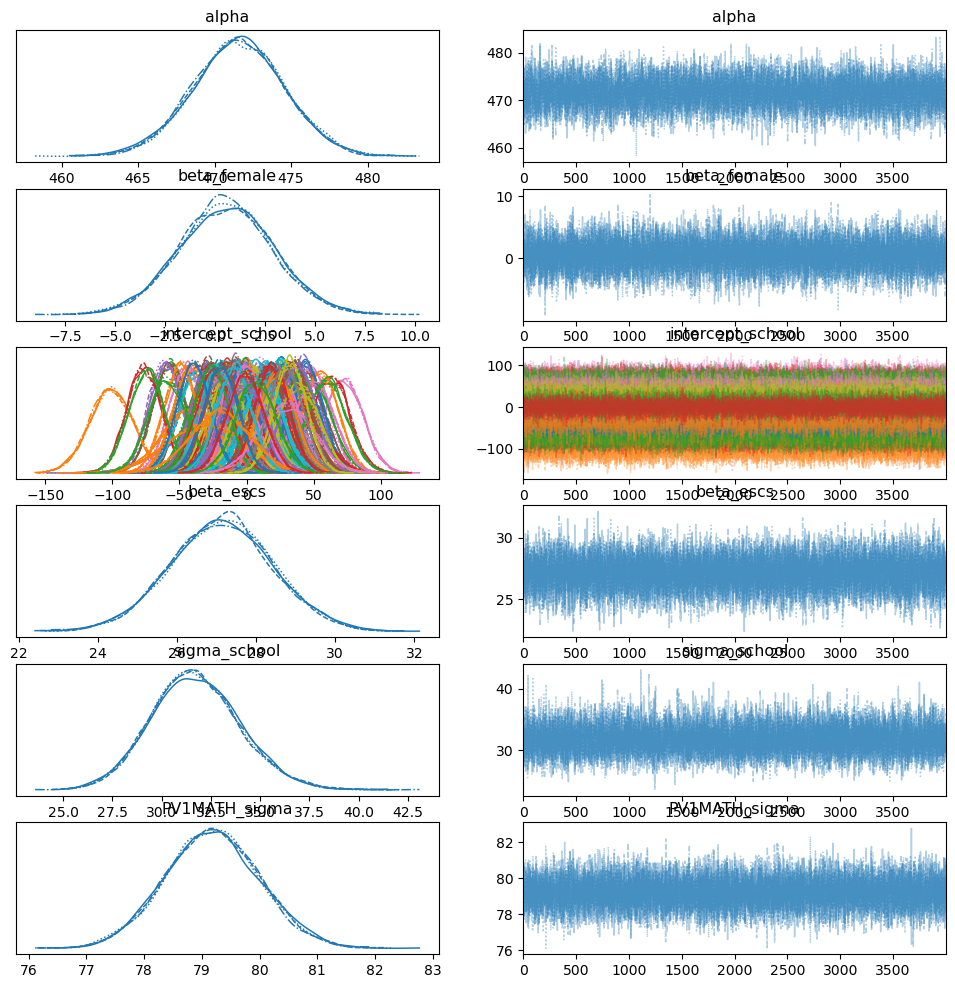

In [6]:
# Visualize the results
az.plot_trace(trace)
plt.plot()

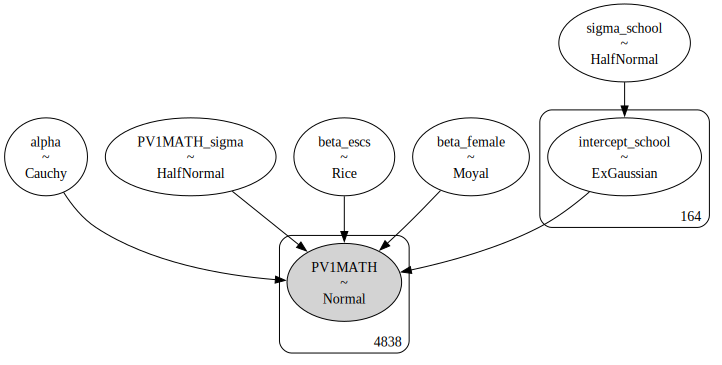

In [7]:
# Plotting a visualization of the model itself
pm.model_graph.model_to_graphviz(non_informative_priors_HLM)

[]

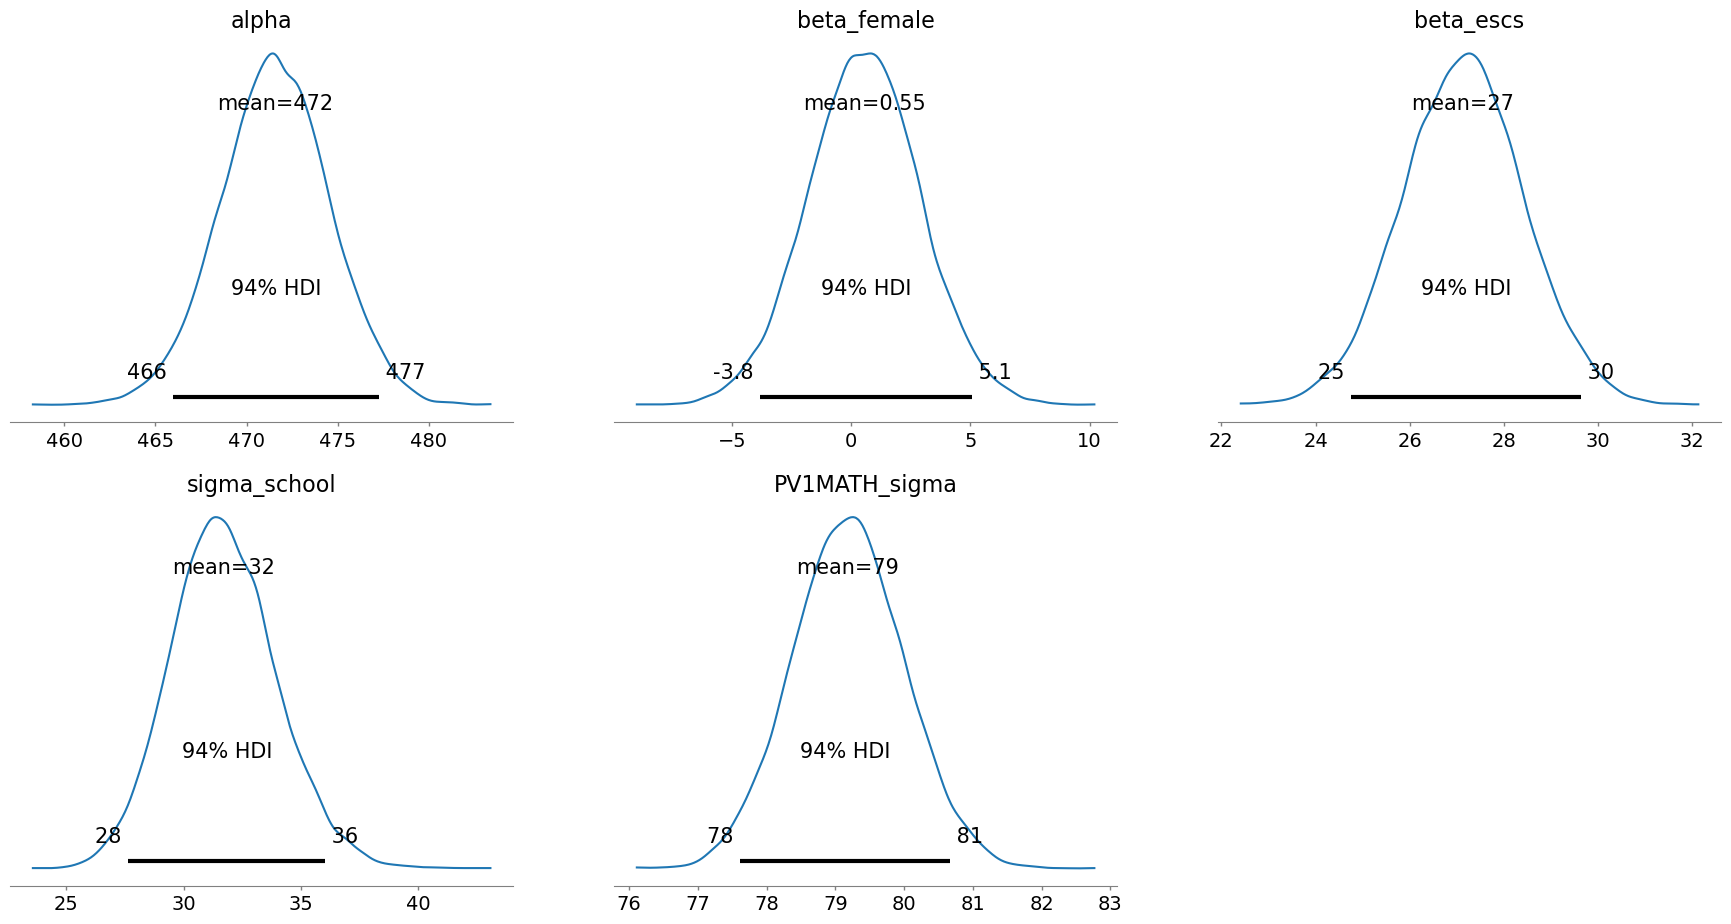

In [8]:
# Plotting the posteriors
az.plot_posterior(trace, var_names=['alpha', 'beta_female', 'beta_escs','sigma_school','PV1MATH_sigma'])
plt.plot()

In [9]:
# Creating the PV1MATH predictions using the model, and calculating the R^2 score and MSE as metrics of accuracy

# Making predictions on the training data
with non_informative_priors_HLM:
    post_pred = pm.sample_posterior_predictive(trace, model=non_informative_priors_HLM)
pred = post_pred.posterior_predictive["PV1MATH"].mean(dim=["chain", "draw"])

# Printing the accuracy metrics
print(f'The R^2 score is: {r2_score(PISA2018["PV1MATH"], pred)}')
print(f'The MSE is: {mean_squared_error(PISA2018["PV1MATH"], pred)}')


The R^2 score is: 0.27521962697154767
The MSE is: 6093.169401489394


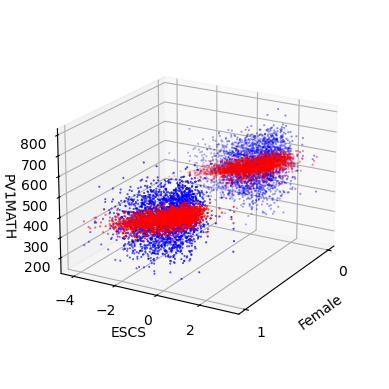

In [10]:
# Plotting the results in 3D, showing the predicted values in red
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=20, azim=30)
ax.scatter3D(PISA2018["Female"], PISA2018["ESCS"], PISA2018["PV1MATH"], s=0.2, c="blue")
ax.scatter3D(PISA2018["Female"], PISA2018["ESCS"], pred, s=0.2, c="red")
ax.set_xlabel("Female")
ax.set_ylabel('ESCS')
ax.set_zlabel("PV1MATH")
ax.set_xticks([0, 1])
ax.set_box_aspect(None, zoom=0.85)
plt.show()